#### A quick demonstration of patchy tau (amplitude modulation) reconstruction in fullsky
#### - this code shows how to compute the estiamtors, and output their power spectra

In [1]:
import numpy as np, basic, curvedsky, plottools as pl, healpy as hp, binning as bn, cmb
from scipy.interpolate import interp1d
from matplotlib.pyplot import *

In [2]:
def sim(nside,lmax,rlmin,rlmax,lcl,cltt,Al,nl,W):
    # gaussian alms are generated, and the reconstructed cls are equal to the normalization
    Talm, Ealm, Balm = curvedsky.utils.gaussTEB(lmax,lcl[0,:],lcl[1,:],lcl[2,:],lcl[3,:])
    # tau map
    tlm = curvedsky.utils.gauss1alm(lmax,cltt)
    tau = curvedsky.utils.hp_alm2map(nside,lmax,lmax,tlm)
    # modulate amplitude in map space
    Talm = curvedsky.utils.mulwin(Talm,np.exp(-tau)*W)
    Ealm, Balm = curvedsky.utils.mulwin_spin(Ealm,Balm,np.exp(-tau)*W)
    # add noise and filtering (temp)
    Talm += curvedsky.utils.gauss1alm(lmax,nl[0,:])
    Ealm += curvedsky.utils.gauss1alm(lmax,nl[1,:])
    Balm += curvedsky.utils.gauss1alm(lmax,nl[2,:])
    # simple diagonal c-inverse
    Fl = np.zeros((3,lmax+1,lmax+1))
    for l in range(rlmin,rlmax):
        Fl[:,l,0:l+1] = 1./ocl[:3,l,None]
    Talm *= Fl[0,:,:]
    Ealm *= Fl[1,:,:]
    Balm *= Fl[2,:,:]
    # compute unnormalized estiamtors
    alm = {}
    alm['TT'] = curvedsky.rec_tau.qtt(lmax,rlmin,rlmax,lcl[0,:],Talm,Talm)
    alm['EB'] = curvedsky.rec_tau.qeb(lmax,rlmin,rlmax,lcl[1,:],Ealm,Balm)
    # compute auto and cross spectra
    xl, cl = {}, {}
    for qest in ['TT','EB']:
        xl[qest] = curvedsky.utils.alm2cl(lmax,-Al[qest][:,None]*alm[qest],tlm)/np.mean(W**2)
        cl[qest] = curvedsky.utils.alm2cl(lmax,-Al[qest][:,None]*alm[qest])/np.mean(W**4)
    tl = curvedsky.utils.alm2cl(lmax,tlm)
    return xl['TT'], xl['EB'], cl['TT'], cl['EB'], tl

In [3]:
# define parameters
Tcmb  = 2.726e6    # CMB temperature
lmax  = 4096       # maximum multipole of output normalization
rlmin, rlmax = 100, lmax  # reconstruction multipole range
sig   = 1.
ac2rad = np.pi/180./60.
L = np.linspace(0,lmax,lmax+1)
# for sim
simn = 10
nside = 2048

#### Load unlensed and lensed Cls

In [4]:
lcl = cmb.read_camb_cls('../data/lensedcls.dat',ftype='lens',output='array')[:,:lmax+1]
lcl[2,:] *= 0.1
nl  = np.zeros((4,lmax+1))
nl[0,:] = (sig*ac2rad/Tcmb)**2
nl[1,:] = 2*nl[0,:]
nl[2,:] = 2*nl[0,:]
ocl = lcl + nl
ocl[0,3001:] = 1e30

#### Load a theory tau spectrum

In [5]:
li, cltti = (np.loadtxt('../data/tt_TH_R5.0_a0.0.dat',usecols=(0,1))).T
tt = interp1d(np.concatenate(([0],li,[lmax])),np.concatenate(([0],cltti,[0])))
cltt = tt(L)

#### Calculate normalizations

In [6]:
Al = {}
Al['TT'] = curvedsky.norm_quad.qtt('amp',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])[0]
Al['EB'] = curvedsky.norm_quad.qeb('amp',lmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:])[0]

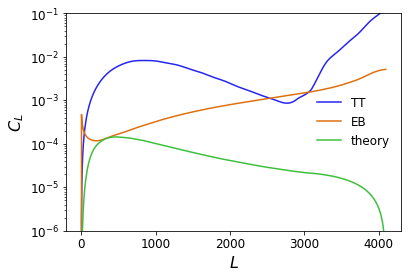

In [7]:
pl.plot_1dstyle(ylog=True,ymin=1e-6,ymax=1e-1)
plot(L,L**2*Al['TT']/np.sqrt(L+0.5),label='TT')
plot(L,L**2*Al['EB']/np.sqrt(L+0.5),label='EB')
plot(L,L**2*cltt,label='theory')
legend()

#### Running simulation

In [8]:
# load mask
#W = hp.fitsfunc.read_map('../data/COM_Mask_Lensing_2048_R2.00_a1.0deg.fits',verbose=False)
#W = hp.ud_grade(W,nside)
W = 1.

In [9]:
xl = np.zeros((simn,5,lmax+1))
for i in range(simn):
    print(i)
    xl[i,:,:] = sim(nside,lmax,rlmin,rlmax,lcl,cltt,Al,nl,W)

0
1
2
3
4
5
6
7
8
9


In [10]:
mb = bn.multipole_binning(20)
xls = bn.binning(xl,mb)
mxl = np.mean(xls,axis=0)
vxl = np.std(xls,axis=0)

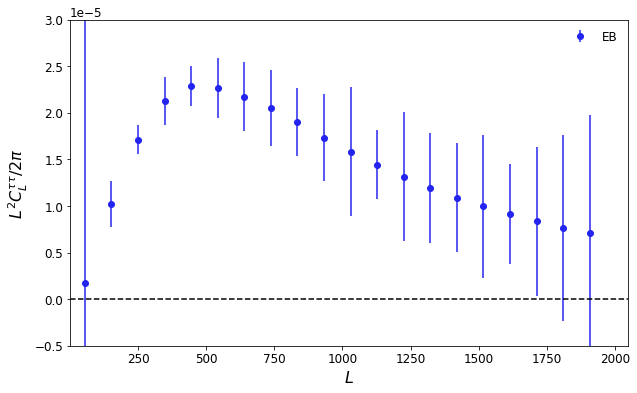

In [11]:
pl.plot_1dstyle(fsize=[10,6],xmin=1,xmax=2048,ymin=-5e-6,ymax=3e-5,ylab=r'$L^2C_L^{\tau\tau}/2\pi$',xlab='$L$')
s = mb.bc**2/2/np.pi
AbTT = bn.binning(Al['TT'],mb)
AbEB = bn.binning(Al['EB'],mb)
#errorbar(mb.bc-5,s*(tt(mb.bc)),yerr=s*vxl[2,:],fmt='o',label='TT')
errorbar(mb.bc+5,s*(tt(mb.bc)),yerr=s*vxl[3,:],fmt='o',label='EB')
axhline(0,color='k',ls='--')
legend()

In [12]:
#pl.plot_1dstyle(fsize=[10,6],xmin=1,xmax=2048,ymin=-2e-4,ymax=2e-4,ylab=r'$C_L^{\tau\tau}$',xlab='$L$')
#errorbar(mb.bc+10,s*(mxl[2,:]-AbTT),yerr=s*vxl[2,:],fmt='o',label='TT')
#errorbar(mb.bc,s*(mxl[3,:]-AbEB),yerr=s*vxl[3,:],fmt='o',label='EB')
#plot(L,L**2/2/np.pi*cltt,label='input')
#legend()

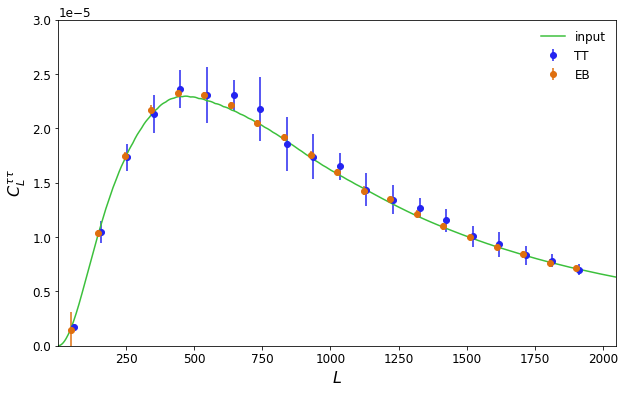

In [13]:
pl.plot_1dstyle(fsize=[10,6],xmin=1,xmax=2048,ymin=0,ymax=3e-5,ylab=r'$C_L^{\tau\tau}$',xlab='$L$')
s = mb.bc**2/2/np.pi
errorbar(mb.bc+10,s*mxl[0,:],yerr=s*vxl[0,:],fmt='o',label='TT')
errorbar(mb.bc,s*mxl[1,:],yerr=s*vxl[1,:],fmt='o',label='EB')
plot(L,L**2/2/np.pi*cltt,label='input')
legend()